In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [83]:
spx_path = "data/SPX_database_2010.xlsx"
df_tri = pd.read_excel(spx_path, sheet_name="total_ret").set_index("Dates")

df_sofr = pd.read_excel("./data/sofr.xlsx")
df_sofr.rename(columns={"Data": "Dates"}, inplace=True)
df_sofr["Dates"] = pd.to_datetime(df_sofr["Dates"]) 
df_sofr = df_sofr.set_index("Dates").sort_index()
df_sofr["Taxa_diaria"] = ((1 + df_sofr["Price"]) ** (1/252)) -1
df_sofr

,Price,Taxa_diaria
Dates,,
2014-01-02,0.0005,0.000002
2014-01-03,0.0005,0.000002
2014-01-06,0.0005,0.000002
2014-01-07,0.0004,0.000002
2014-01-08,0.0004,0.000002
...,...,...
2025-07-28,0.0436,0.000169
2025-07-29,0.0436,0.000169
2025-07-30,0.0432,0.000168


In [84]:
# df_tri = df_tri[(df_tri.index.year >= 2000)]
df_sofr = df_sofr[(df_sofr.index.year >= 2000) ]
prices = df_tri.copy()
returns = prices.pct_change()

/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_21951/850101438.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change()


In [85]:
def _choose_30(tri_df, random_state=42):
    eligible = sorted(list(map(str, tri_df.columns)))
    rng = np.random.default_rng(random_state)
    chosen = rng.choice(eligible, size=min(30, len(eligible)), replace=False)
    return list(map(str, chosen))

tickers_30 = _choose_30(prices)
tickers_30[:5]

['MSI UN Equity.1',
 'K UN Equity.1',
 'GRMN UN Equity',
 'SW UN Equity.1',
 'AVGO UW Equity.1']

In [86]:
prices = prices[tickers_30]
returns = returns[tickers_30]
prices = df_tri.copy()
prices.index = pd.to_datetime(prices.index)
prices = prices.select_dtypes(include=[np.number]).dropna(how="all", axis=1)

In [87]:
def cross_sectional_momentum(prices, lookback=252, skip=21, holding=60, top_k=10):
    returns = prices.pct_change()
    portfolio = []

	# rebalance loop
    for t in range(lookback + skip, len(prices) - holding, holding):
        p_end = prices.iloc[t - skip]
        p_start = prices.iloc[t - skip - lookback]
        score = (p_end / p_start - 1).dropna() # momentum signal

        k = min(top_k, len(score)//2)

        winners = score.nlargest(k).index
        losers = score.nsmallest(k).index
        cols = winners.union(losers)

		# half of notional in longs (for winners) and half in shorts (for losers)
        w = pd.Series(0.0, index=prices.columns)
        w.loc[winners] = +0.5 / len(winners)
        w.loc[losers] = -0.5 / len(losers)

		# portfolio returns = daily rets * weights
        window = returns.iloc[t+1 : t+1+holding][cols].dropna(axis=1, how="any")
        port_returns = window.dot(w.loc[window.columns])
        portfolio.append(port_returns)

    cs_rets = pd.concat(portfolio)
    cs_rets.name = "CS"
    return cs_rets

In [88]:
def time_series_momentum(prices, lookback=252, skip=21, holding=60):
    returns = prices.pct_change()
    portfolio = []
    
    for t in range(lookback + skip, len(prices) - holding, holding):
        p_end   = prices.iloc[t - skip]
        p_start = prices.iloc[t - skip - lookback]
        score = (p_end / p_start - 1).dropna()

        signal = np.sign(score) # +1, -1 or 0 depending on momentum
        active = signal[signal != 0]

        w = active / len(active) # 1/N weights for active assets
        window = returns.iloc[t+1 : t+1+holding][w.index].dropna(axis=1, how="any")

		# normalize so that sum of abs(weights) = 1
        w2 = w.loc[window.columns]
        w2 = w2 / w2.abs().sum()

        port_returns = window.dot(w2)
        port_returns.name = "TS"
        portfolio.append(port_returns)

    ts_rets = pd.concat(portfolio)
    ts_rets.name = "TS"
    return ts_rets

                CS      TS
Ann.Return  0.0353  0.0440
Ann.Vol     0.2044  0.1126
Sharpe      0.1726  0.3910


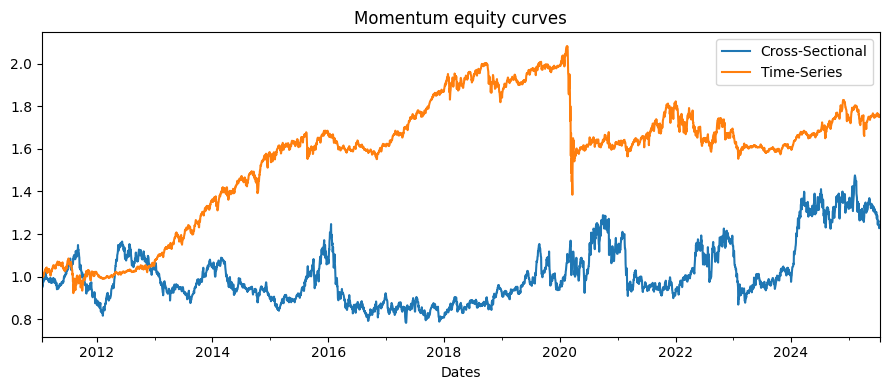

In [89]:
cs_ret = cross_sectional_momentum(prices, lookback=252, skip=21, holding=60, top_k=10)
ts_ret = time_series_momentum(prices, lookback=252, skip=21, holding=60)

def equity(ret): 
    return (1 + ret).cumprod()

def stats(ret):
    mu = ret.mean() * 252
    vol = ret.std(ddof=0) * np.sqrt(252)
    sharpe = mu / vol if vol > 0 else np.nan
    return pd.Series({"Ann.Return": mu, "Ann.Vol": vol, "Sharpe": sharpe})

eq_cs = equity(cs_ret)
eq_ts = equity(ts_ret)

print(pd.concat({"CS": stats(cs_ret), "TS": stats(ts_ret)}, axis=1).round(4))

ax = eq_cs.plot(figsize=(9,4), title="Momentum equity curves")
eq_ts.plot(ax=ax)
plt.legend(["Cross-Sectional", "Time-Series"])
plt.tight_layout()
plt.show()

In [90]:
def to_monthly(ret_daily: pd.Series) -> pd.Series:
    return ret_daily.groupby(pd.Grouper(freq="ME")).apply(lambda x: (1.0 + x).prod() - 1.0)

def t_stat(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 3:
        return np.nan
    mu = x.mean()
    se = x.std(ddof=1) / np.sqrt(len(x))
    return mu / se if se > 0 else np.nan

def days(m):
    return int(round(m * 21))

In [91]:
def tstat_grid_TS(prices, lookbacks_m, holdings_m, skip_m=1):
    tbl = pd.DataFrame(index=lookbacks_m, columns=holdings_m, dtype=float)
    for L in lookbacks_m:
        for H in holdings_m:
            ts = time_series_momentum(
                prices,
                lookback=days(L),
                skip=days(skip_m),
                holding=days(H),
            )
            ts_m = to_monthly(ts)
            tbl.loc[L, H] = t_stat(ts_m)
    tbl.index.name = "Lookback (m)"
    tbl.columns.name = "Holding (m)"
    return tbl

def tstat_grid_CS(prices, lookbacks_m, holdings_m, skip_m=1, top_k=10):
    tbl = pd.DataFrame(index=lookbacks_m, columns=holdings_m, dtype=float)
    for L in lookbacks_m:
        for H in holdings_m:
            cs = cross_sectional_momentum(
                prices,
                lookback=days(L),
                skip=days(skip_m),
                holding=days(H),
                top_k=top_k,
            )
            cs_m = to_monthly(cs)
            tbl.loc[L, H] = t_stat(cs_m)
    tbl.index.name = "Lookback (m)"
    tbl.columns.name = "Holding (m)"
    return tbl

TS Momentum — t-stats (lookback x holding)


Holding (m),1,3,6,9,12,24,36,48
Lookback (m),,,,,,,,
1,0.87,1.95,0.61,0.45,0.65,2.43,-0.76,1.07
3,0.69,0.79,-0.06,0.07,1.28,2.08,-0.15,3.65
6,1.44,1.89,4.38,2.27,5.32,3.45,2.29,3.35
9,2.40,2.31,1.19,3.95,2.42,2.36,3.19,3.83
12,2.63,2.67,4.51,2.21,3.40,3.16,2.91,4.26
24,3.16,3.24,3.88,3.61,3.46,3.63,3.49,4.19
36,3.27,3.44,3.86,3.59,3.82,3.54,3.76,3.92
48,3.21,3.31,3.81,3.49,3.80,3.67,3.67,3.60


CS Momentum — t-stats (lookback x holding)


Holding (m),1,3,6,9,12,24,36,48
Lookback (m),,,,,,,,
1,-0.31,-1.10,-2.21,-1.51,-2.49,-1.56,-1.67,-0.06
3,-0.04,0.13,-0.30,-0.35,0.91,-0.03,0.30,1.01
6,0.71,0.85,1.28,1.03,2.02,0.53,0.58,1.59
9,0.39,0.85,-0.02,1.72,0.48,-0.20,-0.67,-0.36
12,0.60,1.07,1.18,1.56,0.37,-1.40,-1.57,-1.41
24,0.39,1.11,1.11,0.33,0.27,-0.59,-0.99,-1.25
36,-0.19,0.35,0.60,0.33,0.58,-0.86,-0.09,-0.99
48,0.48,0.47,0.40,-0.35,0.02,-0.12,-0.34,-0.95


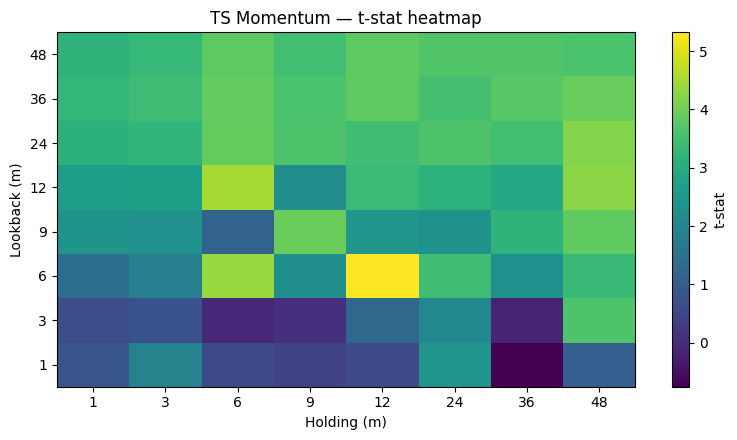

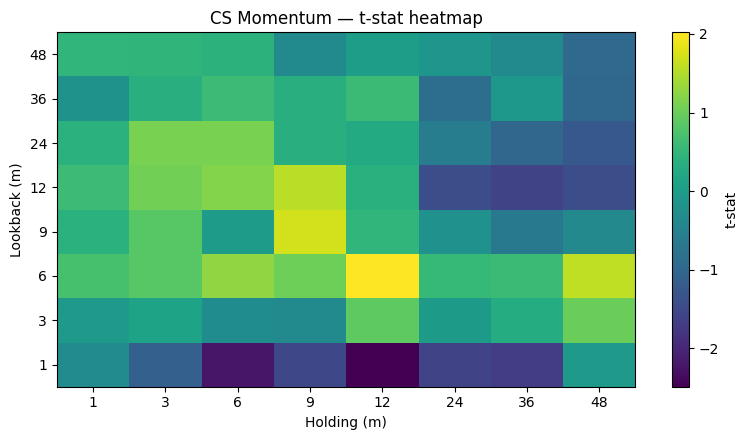

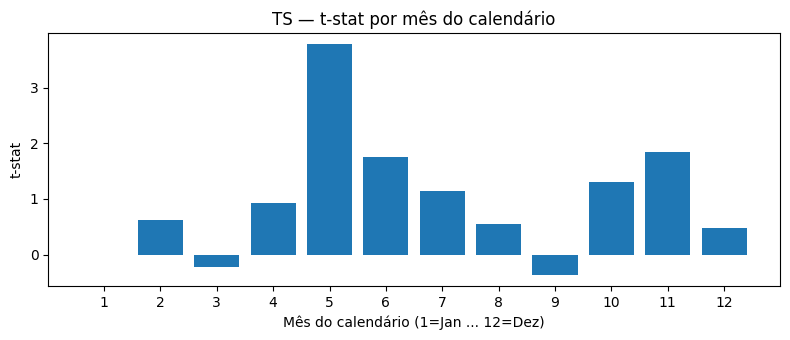

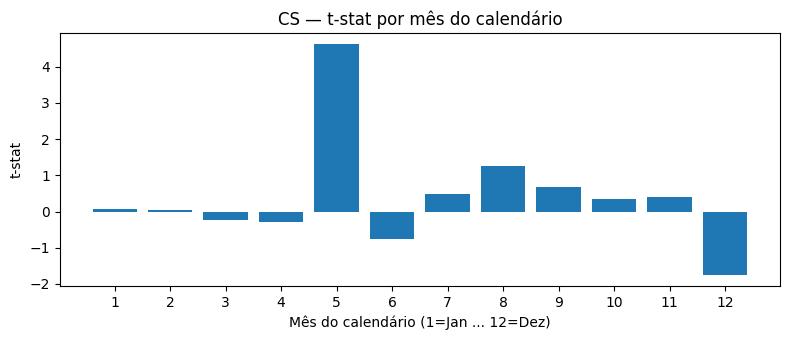

In [92]:
def plot_heatmap(df, title):
    fig, ax = plt.subplots(figsize=(8,4.5))
    im = ax.imshow(df.values.astype(float), aspect="auto", origin="lower")
    ax.set_xticks(range(len(df.columns)), labels=[str(c) for c in df.columns])
    ax.set_yticks(range(len(df.index)), labels=[str(i) for i in df.index])
    ax.set_xlabel(df.columns.name or "")
    ax.set_ylabel(df.index.name or "")
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("t-stat")
    plt.tight_layout()
    plt.show()

def plot_tstat_by_calendar_month(ret_daily: pd.Series, title):
    r_m = to_monthly(ret_daily)
    by_m = r_m.groupby(r_m.index.month).apply(t_stat)
    fig, ax = plt.subplots(figsize=(8,3.5))
    ax.bar(by_m.index, by_m.values)
    ax.set_xticks(range(1,13))
    ax.set_xlabel("Mês do calendário (1=Jan ... 12=Dez)")
    ax.set_ylabel("t-stat")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
prices = df_tri.copy()
prices.index = pd.to_datetime(prices.index)
prices = prices.select_dtypes(include=[np.number]).dropna(how="all", axis=1)

lookbacks_m = [1,3,6,9,12,24,36,48]
holdings_m  = [1,3,6,9,12,24,36,48]
skip_m = 1
top_k = 10

ts_tbl = tstat_grid_TS(prices, lookbacks_m, holdings_m, skip_m=skip_m)
cs_tbl = tstat_grid_CS(prices, lookbacks_m, holdings_m, skip_m=skip_m, top_k=top_k)

print("TS Momentum — t-stats (lookback x holding)")
display(ts_tbl.round(2))

print("CS Momentum — t-stats (lookback x holding)")
display(cs_tbl.round(2))

plot_heatmap(ts_tbl, "TS Momentum — t-stat heatmap")
plot_heatmap(cs_tbl, "CS Momentum — t-stat heatmap")

ts_example = time_series_momentum(prices, lookback=days(12), skip=days(1), holding=days(3))
cs_example = cross_sectional_momentum(prices, lookback=days(12), skip=days(1), holding=days(3), top_k=top_k)

plot_tstat_by_calendar_month(ts_example, "TS — t-stat por mês do calendário")
plot_tstat_by_calendar_month(cs_example, "CS — t-stat por mês do calendário")


/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_21951/3313448931.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_21951/3313448931.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_21951/3313448931.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 

Top ['NFLX UW Equity', 'NFLX UW Equity.1', 'AKAM UW Equity', 'AKAM UW Equity.1', 'UAL UW Equity', 'UAL UW Equity.1', 'HBAN UW Equity', 'HBAN UW Equity.1', 'CMG UN Equity', 'CMG UN Equity.1', 'LVS UN Equity', 'LVS UN Equity.1', 'CMI UN Equity', 'CMI UN Equity.1', 'FFIV UW Equity', 'FFIV UW Equity.1', 'KEY UN Equity', 'KEY UN Equity.1', 'HSY UN Equity', 'HSY UN Equity.1', 'TSN UN Equity', 'TSN UN Equity.1', 'WYNN UW Equity', 'WYNN UW Equity.1', 'DXCM UW Equity', 'DXCM UW Equity.1', 'INCY UW Equity', 'INCY UW Equity.1', 'FITB UW Equity', 'FITB UW Equity.1', 'IT UN Equity', 'IT UN Equity.1', 'MTB UN Equity', 'MTB UN Equity.1', 'EQR UN Equity', 'EQR UN Equity.1', 'EL UN Equity', 'EL UN Equity.1', 'RF UN Equity', 'RF UN Equity.1', 'DG UN Equity', 'DG UN Equity.1', 'DLTR UW Equity', 'DLTR UW Equity.1', 'MOH UN Equity', 'MOH UN Equity.1', 'LULU UW Equity', 'LULU UW Equity.1', 'TSCO UW Equity', 'TSCO UW Equity.1', 'CRM UN Equity', 'CRM UN Equity.1', 'AZO UN Equity', 'AZO UN Equity.1', 'SMCI UW 

/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_21951/3313448931.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_21951/3313448931.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_21951/3313448931.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 

Dates                 
2010-08-17  Periodo 1     0.996352
2010-08-18  Periodo 1     1.000157
2010-08-19  Periodo 1     1.000586
2010-08-20  Periodo 1     1.010449
2010-08-23  Periodo 1     1.001801
                            ...   
2025-04-28  Periodo 28    0.626511
2025-04-29  Periodo 28    0.623804
2025-04-30  Periodo 28    0.620429
2025-05-01  Periodo 28    0.645095
2025-05-02  Periodo 28    0.653308
Length: 1652, dtype: float64

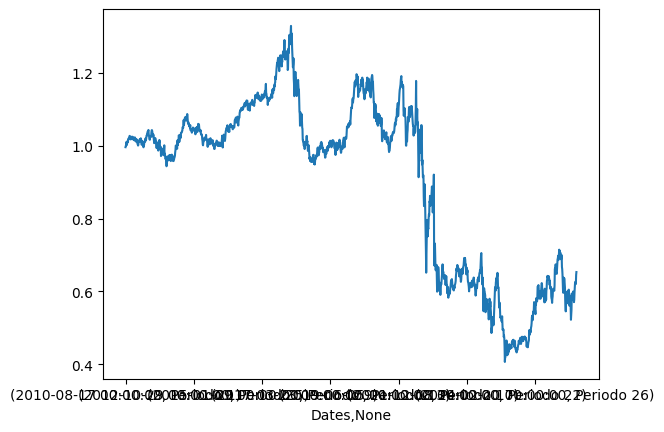

In [93]:
def momentum_simple_daily(prices) -> pd.DataFrame:
    rets = prices.pct_change()
    log1p = np.log1p(rets)
    cum_log = log1p.cumsum()
    score = np.expm1(cum_log)
    score 
    return score.iloc[-1]

def rebalanciar(df):
    ranking = momentum_simple_daily(df)
    num_nans = ranking.isna().sum()

    top = ranking.nlargest(15 + (num_nans // 2)).index.tolist()
    last = ranking.nsmallest(15 + (num_nans // 2)).index.tolist()
    print("Top", top, "Last", last)
    return top, last

def portifolio(df, janela, skip, holding):
    janelas = df.shape[0] // janela
    retornos = []

    for i in range(int(janelas)):
        janela_start = 0 if i == 0 else max(0, (i - 1) * janela)
        corte = min((i + 1) * janela, len(df))

        top, last = rebalanciar(df.iloc[janela_start:corte])



        start = corte + skip
        end   = min(start + holding, len(df))
        if start >= end:
            break

        retorno_top  = df.iloc[start:end][top].pct_change().iloc[1:]  
        retorno_last = df.iloc[start:end][last].pct_change().iloc[1:] * -1
        r = (retorno_top.mean(axis=1) + retorno_last.mean(axis=1)).to_frame(name=f"Periodo {i+1}")
        retornos.append(r)

    return retornos

teste = portifolio(df_tri, janela=140, skip=21, holding=60)
teste = pd.concat(teste) 
teste = teste.stack().sort_index(level=0)
teste = (teste + 1).cumprod()
teste.plot()
teste


In [94]:
serie_unica = teste.stack().sort_index(level=0)

# retorno acumulado total
ret_acum_total = (1 + serie_unica/100).prod() - 1

print("Retorno acumulado total:", f"{ret_acum_total:.2%}")


AttributeError: 'Series' object has no attribute 'stack'

In [ ]:
serie_unica

Dates                 
2014-08-15  Periodo 1     0.998109
2014-08-18  Periodo 1     0.995843
2014-08-19  Periodo 1     0.990582
2014-08-20  Periodo 1     0.995840
2014-08-21  Periodo 1     0.992906
                            ...   
2023-12-14  Periodo 18    1.063898
2023-12-15  Periodo 18    1.069464
2023-12-18  Periodo 18    1.069366
2023-12-19  Periodo 18    1.072189
2023-12-20  Periodo 18    1.069544
Length: 1062, dtype: float64

Cross-sectional Momentum

 Rank assets by measures of past performance: lookback period

 
 Buy winners and short losers
 
 Hold assets for a pre-defined periods: holding period
 
 Symmetric: buy and sell same number of assets or at least same 
notional

Time-series Momentum

 Analyze performance of each asset individually with same metric: 
lookback period

 Buy winners and short losers

 Hold assets for a pre-defined periods: holding period

 Assymmetric: you may even buy all assets or sell all assets

